In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn import svm
from keras.datasets import imdb

2023-06-16 12:02:44.433566: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 12:02:44.679344: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 12:02:44.680780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 12:02:45.936654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the dataset

In [2]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
max_length = 500
vocab_size = 60000

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    path="imdb.npz",
    num_words=vocab_size,
    skip_top=10,
    maxlen=max_length,
    seed=113,
    start_char=start_char,
    oov_char=oov_char,
    index_from=index_from,
)

print(x_train.shape, x_test.shape)

# Retrieve the word index file mapping words to indices
word_index = imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[2])
decoded_sequence

(22882,) (23065,)


"[OOV] this has [OOV] be one [OOV] [OOV] worst films [OOV] [OOV] 1990s when my friends i were watching this film being [OOV] target audience it was aimed at we just sat watched [OOV] first half an hour with our jaws touching [OOV] floor at how bad it really was [OOV] rest [OOV] [OOV] time everyone else in [OOV] theatre just started talking [OOV] each other leaving or generally crying into their popcorn that they actually paid money they had earnt working [OOV] watch this feeble excuse for [OOV] film it must have looked like [OOV] great idea on paper but on film it looks like no one in [OOV] film has [OOV] clue what [OOV] going on crap acting crap costumes i can't get across how embarrasing this [OOV] [OOV] watch save yourself an hour [OOV] bit [OOV] your life"

In [3]:
train_size = 20000
test_size = 2000
x_train = x_train[:train_size]
y_train = y_train[:train_size]
x_test = x_test[:test_size]
y_test = y_test[:test_size]

## NN

In [4]:
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn

In [5]:
def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': x_data[i:i+batch_size],
            'y': y_data[i:i+batch_size]})
    return batches

def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y))

In [32]:
def run_epoch(data, model, optimizer, embedding_matrix=False):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in data:#tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions
        # if(embedding_matrix):
        emb =  torch.tensor(embedding_matrix[x], dtype=torch.float32) 
        out = model(emb.view(-1, 50 * 500))
        # else:
            # out = model(x)

        # Predict and store accuracy
        predictions = torch.argmax(out, dim=1)
        batch_accuracies.append(compute_accuracy(predictions, y))

        # Compute loss
        # loss = F.binary_cross_entropy(out, torch.tensor(y, dtype=torch.long)) + 0.1*sum(torch.norm(p) for p in model.parameters())
        loss = F.cross_entropy(out, torch.tensor(y, dtype=torch.long)) + 0.1*sum(torch.norm(p) for p in model.parameters())
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

def train_model(train_data, dev_data, model, lr=0.1, momentum=0.1, nesterov=False, n_epochs=30, embedding_matrix=False):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    epochs_i = []
    losses_i = []
    val_losses_i = []
    val_accs_i = []

    for epoch in range(1, n_epochs+1):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        loss, acc = run_epoch(train_data, model.train(), optimizer, embedding_matrix)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))
        losses_i.append(loss)
        epochs_i.append(epoch)
        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer, embedding_matrix)
        val_losses_i.append(val_loss)
        val_accs_i.append(val_acc)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        # Save model
        torch.save(model, "/notebooks/Sentiment_analysis_IMDB.pt")
    return losses_i, val_losses_i, val_accs_i, epochs_i

In [7]:
# Download and load pre-trained word embeddings (e.g., GloVe)
embedding_dim = 50
embedding_index = {}
with open('/notebooks/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

In [13]:
# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size + index_from, embedding_dim), dtype=np.float32)
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i + index_from] = embedding_vector

In [14]:
word_index["good"], embedding_index.get("good"), embedding_matrix[49+index_from]

(49,
 array([-3.5586e-01,  5.2130e-01, -6.1070e-01, -3.0131e-01,  9.4862e-01,
        -3.1539e-01, -5.9831e-01,  1.2188e-01, -3.1943e-02,  5.5695e-01,
        -1.0621e-01,  6.3399e-01, -4.7340e-01, -7.5895e-02,  3.8247e-01,
         8.1569e-02,  8.2214e-01,  2.2220e-01, -8.3764e-03, -7.6620e-01,
        -5.6253e-01,  6.1759e-01,  2.0292e-01, -4.8598e-02,  8.7815e-01,
        -1.6549e+00, -7.7418e-01,  1.5435e-01,  9.4823e-01, -3.9520e-01,
         3.7302e+00,  8.2855e-01, -1.4104e-01,  1.6395e-02,  2.1115e-01,
        -3.6085e-02, -1.5587e-01,  8.6583e-01,  2.6309e-01, -7.1015e-01,
        -3.6770e-02,  1.8282e-03, -1.7704e-01,  2.7032e-01,  1.1026e-01,
         1.4133e-01, -5.7322e-02,  2.7207e-01,  3.1305e-01,  9.2771e-01],
       dtype=float32),
 array([-3.5586e-01,  5.2130e-01, -6.1070e-01, -3.0131e-01,  9.4862e-01,
        -3.1539e-01, -5.9831e-01,  1.2188e-01, -3.1943e-02,  5.5695e-01,
        -1.0621e-01,  6.3399e-01, -4.7340e-01, -7.5895e-02,  3.8247e-01,
         8.1569e-02,  

In [15]:
# make all the reviews of the same size by padding
x_train_padded = np.zeros((train_size, max_length), dtype=int)
x_test_padded = np.zeros((test_size, max_length), dtype=int)

for i in range(0, train_size):
  if(len(x_train[i]) < max_length):
    x_train_padded[i] = np.pad(x_train[i], (0, max_length - len(x_train[i])), mode="constant", constant_values = 0)

for i in range(0, test_size):
  if(len(x_test[i]) < max_length):
    x_test_padded[i] = np.pad(x_test[i], (0, max_length - len(x_test[i])), mode="constant", constant_values = 0)

x_train_padded.shape, x_test_padded.shape

((20000, 500), (2000, 500))

In [242]:
emb_x = embedding_matrix[x_train_padded[[1,2]]]
emb_x.shape

(2, 500, 50)

In [16]:
# create batches for SGD
batch_size = 32
train_batches = batchify_data(x_train_padded, y_train, batch_size)
test_batches = batchify_data(x_test_padded, y_test, batch_size)

In [17]:
train_batches[0]["x"].shape

(32, 500)

In [33]:
#################################
# Model specification TODO
model = nn.Sequential(
          nn.Linear(max_length * embedding_dim, 128),
          nn.Tanh(),
          nn.Linear(128, 128),
          nn.Tanh(),
          nn.Linear(128, 2),
          # nn.Sigmoid()
        )

In [34]:
# train the model
losses_i, val_losses_i, val_accs, epochs_i = train_model(train_batches, test_batches, model, lr=0.01, momentum = 0.9, nesterov=True, n_epochs = 10, embedding_matrix=embedding_matrix,)

# # Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, model.eval(), None, embedding_matrix=embedding_matrix)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs_i, losses_i, label = "Train loss")
plt.plot(epochs_i, val_losses_i, label = "Val loss")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(epochs_i, val_accs)
plt.show()

In [169]:
stepi = []
lossi = []

In [170]:
import random
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

for i in range(1000):
  # minibatch construct
  # forward pass
  ix = []
  for j in range(64):
    ix.append(random.randint(0,len(x_train_padded)-1))

  emb =  torch.tensor(embedding_matrix[x_train_padded[ix]], dtype=torch.float32) 
  out = model(emb.view(-1, embedding_dim * max_length))
  # print(out.shape)
  loss = F.cross_entropy(out, torch.tensor(y_train_pad[ix])) #+ sum(torch.norm(p) for p in model.parameters())
  
  #update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # scheduler.step()

  stepi.append(i)
  lossi.append(loss.log10().data.item())

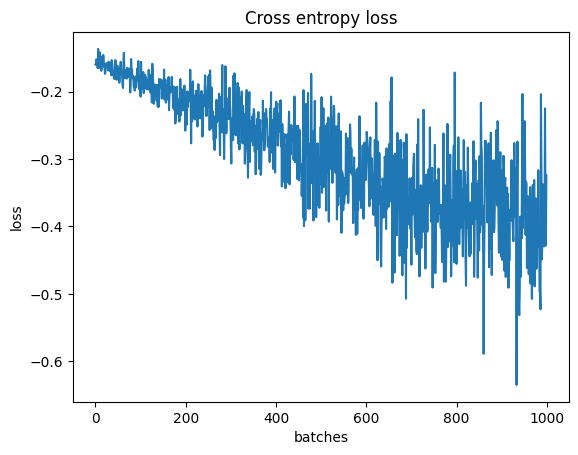

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Cross entropy loss")
plt.ylabel("loss")
plt.xlabel("batches")
plt.plot(stepi, lossi)